In [65]:
import halotools
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

#halotools.test_installation()

1) Import data
==

In [2]:
from halotools import sim_manager
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname = 'bolplanck', halo_finder = 'rockstar', redshift = 0)

In [3]:
#Catalog of halos itself
halos = halocat.halo_table
#To see what properties are available 
print(halos.keys())

['halo_vmax_firstacc', 'halo_dmvir_dt_tdyn', 'halo_macc', 'halo_scale_factor', 'halo_vmax_mpeak', 'halo_m_pe_behroozi', 'halo_delta_vmax_behroozi17', 'halo_xoff', 'halo_spin', 'halo_tidal_force', 'halo_scale_factor_firstacc', 'halo_c_to_a', 'halo_mvir_firstacc', 'halo_scale_factor_last_mm', 'halo_tidal_id', 'halo_scale_factor_mpeak', 'halo_pid', 'halo_m500c', 'halo_id', 'halo_halfmass_scale_factor', 'halo_upid', 'halo_t_by_u', 'halo_rvir', 'halo_vpeak', 'halo_dmvir_dt_100myr', 'halo_mpeak', 'halo_m_pe_diemer', 'halo_jx', 'halo_jy', 'halo_jz', 'halo_m2500c', 'halo_mvir', 'halo_voff', 'halo_axisA_z', 'halo_axisA_x', 'halo_axisA_y', 'halo_y', 'halo_b_to_a', 'halo_x', 'halo_z', 'halo_m200b', 'halo_vacc', 'halo_scale_factor_lastacc', 'halo_vmax', 'halo_m200c', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_dmvir_dt_inst', 'halo_tidal_force_tdyn', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo']


In [17]:

#All metadata associated with a Halotools-formatted halo catalog is accessible via attributes of the CachedHaloCatalog object.

print(halocat.redshift, halocat.Lbox)



-0.0023 [ 250.  250.  250.]


In [21]:
#print(halos["halo_hostid"][-20:])


1444262

In [ ]:
#print(halos[0:9,])

2) Organize the data into main halo and subhalo
==

In [4]:
from halotools.utils import group_member_generator
#Group halos by halo host id
halos.sort('halo_hostid')
grouping_key = 'halo_hostid'
requested_columns = []
group_gen = group_member_generator(halos, grouping_key, requested_columns)

#calculates the number of subalos per host
nsub = np.zeros(len(halos))
for first, last, member_props in group_gen:
    nsub[first:last] = last - first - 1
#Adds a new column to the ith-row of the table which gives the number of subhalos found in the i-th halo
halos['num_subhalos'] = nsub


In [ ]:
#halos[3]

In [5]:
NumberHosthalos=0
NumberSubhalos=0
for i in range(0,len(halos)):
    if halos["halo_pid"][i]==-1:
        NumberHosthalos= NumberHosthalos+1
    else:
        NumberSubhalos = NumberSubhalos+1
        
print("Number of halos in total, unfilterd bolplank catalog", len(halos))
print("Number of hosthalos, unfilterd bolplank catalog", NumberHosthalos)
print("Number of subhalos, unfilterd bolplank catalog", NumberSubhalos)

Number of halos in total, unfilterd bolplank catalog 1444262
Number of hosthalos, unfilterd bolplank catalog 1078614
Number of subhalos, unfilterd bolplank catalog 365648


In [8]:
#Apply mask: consider all subhalos with Vpeak>160km/s hosted by a host with Mvir [Msun/h] > 1e13.5

#The mask for the hosts

host_mask = ((halos['halo_upid'] == -1) &
               (halos['halo_mvir'] > 1e12))
Reduced_hosts = halos[host_mask]

#The mask for the subs needs a little more work:
#First filter all subs from the catalog with Vpeak>160km/s to raw_subs
##
##raw_submask = ((halos["halo_upid"]>0))

##raw_subs = halos[raw_submask]

##create a new column in order to check, whether the filtered subs here are corresponding to a host in the Reduced_hosts
##raw_subs.add_column(raw_subs["halo_pid"], name="check_sub")
               
#Crossmatch both catalogs and put the value in column "check_sub" to 0, if the subhalo belongs to a halo in Reduced_hosts               
##for i in range(0,len(raw_subs)):
   
##   for j in range(0,len(Reduced_hosts)):
        
##        if raw_subs["halo_upid"][i]==Reduced_hosts["halo_id"][j]:
            
##           raw_subs["check_sub"][i]=0
        
##       else:
              # continue
##   

#Reduce raw_subs to subhalos actually corresponding to host halos found in Reduced_hosts:

##sub_maskTest = (raw_subs["check_sub"]==0)
##Reduced_subsTest = raw_subs[sub_maskTest]


#Submask

sub_mask = ((halos["halo_upid"]>0)&(halos["halo_mvir_host_halo"]>1e12))
Reduced_subs = halos[sub_mask]

print("Number of hosthalos, filtered by Mvir [Msun/h] > 1e12 = ", len(Reduced_hosts))
print("Number of subhalos, filtered by  Vpeak>160 km/s = ", len(Reduced_subs))
print("The mean concentration of host halos is  ", "$ \bar{c}$ = ", np.mean(Reduced_hosts['halo_nfw_conc']))


Number of hosthalos, filtered by Mvir [Msun/h] > 1e12 =  65854
Number of subhalos, filtered by not Vpeak>160 km/s =  296479
The mean concentration of host halos is   $ ar{c}$ =  9.18346


0


3)Radial density profile
==

In [9]:
#As with all mock_observables functions that accept 3d positions for arguments, we first format our positions into
#an array of the expected shape.
from halotools import mock_observables
from halotools.mock_observables import return_xyz_formatted_array

Reduced_hosts_pos = return_xyz_formatted_array(Reduced_hosts['halo_x'], Reduced_hosts['halo_y'], Reduced_hosts['halo_z'])
Reduced_subs_pos = return_xyz_formatted_array(Reduced_subs['halo_x'], Reduced_subs['halo_y'], Reduced_subs['halo_z'])
Reduced_hosts_vel = return_xyz_formatted_array(Reduced_hosts['halo_vx'], Reduced_hosts['halo_vy'], Reduced_hosts['halo_vz'])
Reduced_subs_vel = return_xyz_formatted_array(Reduced_subs['halo_vx'], Reduced_subs['halo_vy'], Reduced_subs['halo_vz'])

#The radial_profile_3d function accepts two different kinds of inputs for the separation bins. 
#If you pass in rbins_normalized and normalize_rbins_by, then this combination of arguments allows you to calculate 
#how various quantities vary as a function of, for example, x=r/Rvir.
#The way this works is that the normalize_rbins_by argument stores the value of Rvir

#for each point in sample1, and the rbins_normalized argument will be interpreted as referring to the distance of points
#in sample2 scaled by this value.

#In the following call to the radial_profile_3d function, we will calculate the radial density profile of host halo systems
#with their corresponding subhalos spaced between 0.01<r/Rvir<15.

from halotools.mock_observables import radial_profile_3d

rbins_normalized = np.linspace(0.001, 1, 200)
rbins_midpoints = (rbins_normalized[:-1] + rbins_normalized[1:])/2.

result, counts = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_mvir'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox,return_counts = True)


shell_volumes = 4*np.pi*(rbins_midpoints**2)*np.diff(rbins_normalized)
mean_number_density = (counts/float(len(Reduced_hosts)))/shell_volumes



In [ ]:
#Calculate distances of subhalos to halo center
distance, distance_counts = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_rvir'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox,return_counts = True)

In [60]:
#Model the NFW profile

from halotools import empirical_models
from halotools.empirical_models import NFWProfile

nfw = NFWProfile(conc_mass_model='direct_from_halo_catalog', mdef='vir',concentration_key="halo_nfw_conc",redshift=0)
model_conc = nfw.conc_NFWmodel(table=Reduced_hosts)

#Write NFW profile function yourself:
from halotools.empirical_models import density_threshold
from astropy import cosmology
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
m_dm=1.55e8

def NFW(r):
    return density_threshold(cosmo,0,mdef="vir")*0.3/3*np.mean(Reduced_hosts["halo_nfw_conc"])**3 /(np.log(1+np.mean(Reduced_hosts["halo_nfw_conc"]))+np.mean(Reduced_hosts["halo_nfw_conc"])/(1+np.mean(Reduced_hosts["halo_nfw_conc"])))/(r/np.mean(Reduced_hosts["halo_rs"]))/(1+r/np.mean(Reduced_hosts["halo_rs"]))**2

r_values = np.linspace(0.001,1,41254)
r_values_hosts=np.linspace(0.001,1,65854)
#radii = nfw.mc_generate_nfw_radial_positions(conc=9,halo_mass = (Reduced_hosts["halo_mvir"]))
rho_nfw = nfw.dimensionless_mass_density(scaled_radius =r_values_hosts,conc = Reduced_hosts["halo_nfw_conc"])

In [48]:
#Try for one set
array_of_ids = np.array([])
for i in range(0,len(Reduced_hosts)):
    if Reduced_subs["halo_upid"][i]==Reduced_hosts["halo_id"][13668]:
        array_of_ids = np.append(array_of_ids, i)
    else:
        continue
print("The host with most subhalos is found at", 13668 , " and has ", np.max(Reduced_hosts["num_subhalos"]), " subhalos")

The host with most subhalos is found at 13668  and has  800.0  subhalos


We begin with the analysis of a subsample of the Bolshoi simulation with Planck cosmology as of 2013
(h=0.7, $\Omega_{\Lambda}$=0.69289, $\Omega_{m}$ = 0.30711, $\Omega_b$ = 0.048, $n_s$ =  0.96, $\sigma_8$ = 0.82).
The simulation started at $z_{ini}$ = 80 and followed $2048^3$ particles of mass $M_{dm} = 1.55 \times 10^8$ $M_{sun}/h$ in their evolution in a volume of boxsize L=250 Mpc/h.

The subsample represented here consists of 65854 host halos with virial mass $M_{vir}>10^{12} M_{sun}$, mean concentration $\bar{c} =9.18346$ and 41254 corresponding subhalos with $V_{peak} > 160 km/s$.

The following plot shows the number density profile of the subhalos w.r.t. the distance (scaled by the
virial radius of the corresponding host halo) to their corresponding host halo. An appropriately scaled NFW profile
is plotted for comparison reasons:

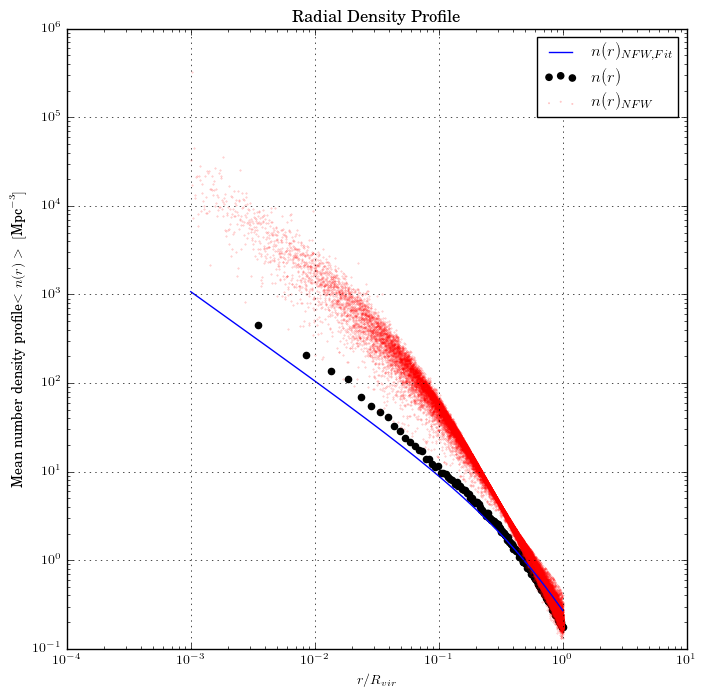

In [79]:
#mean dark matter particle mass in units of Msun/h

#Plot the radial density profile

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Create a new figure 
fig = plt.figure(figsize=(8,8), dpi=80)

# Create subplots
plot_profile = fig.add_subplot(111)



# Plot power spectrum
plot_profile.set_xscale('log')
plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(0.001, 1e3)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'Mean number density profile$ <n(r)>$ $\;[\textrm{Mpc}^{-3}]$')

#plot_profile.scatter(rbins_midpoints, result, color="red", label=r'$\rho(r)$', marker=".")
#plot_profile.plot(r_values,nfw.mass_density(r_values,np.mean(Reduced_hosts["halo_mvir"])/1e10,np.mean(Reduced_hosts['halo_nfw_conc'])), color="navy", label=r"$\rho(r)_{NFW}$")

plot_profile.scatter(rbins_midpoints,mean_number_density, color="black", marker="o",label=r"$n(r)$")
#plot_profile.plot(r_values,NFW(r_values)/np.mean(Reduced_hosts["halo_mvir"]), color="navy", label=r"$\rho(r)_{NFW}/\bar{m}_{host}$")
#plot_profile.plot(r_values,NFW(r_values)/np.mean(Reduced_subs["halo_mvir_host_halo"]), color="red", label=r"$\rho(r)_{NFW}/\bar{m}_{host,subinferred}$")
#plot_profile.plot(r_values,NFW(r_values)/np.mean(Reduced_subs["halo_mvir"]), color="orange", label=r"$\rho(r)_{NFW}/\bar{m}_sub$")
plot_profile.scatter(r_values_hosts,rho_nfw, color="red", marker=".",label=r"$n(r)_{NFW}$", alpha=0.3,s=0.5)

def NfwFit(A, x):
    return A/x/(1+x)**2

popt,pcov = curve_fit(NfwFit, rbins_midpoints, mean_number_density)
plot_profile.plot(r_values_hosts, 3.3*NfwFit(popt[0],r_values_hosts),label="$n(r)_{NFW, Fit}$")

plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Radial Density Profile")
# Save figure using 80 dots per inch
plt.savefig("RadialDensityProfile.pdf",dpi=80)


In [13]:
print("Highest host halo mass = ", np.max(Reduced_hosts["halo_mvir"]), "[$M_{sun} /h$]")
print("Highest host halo mass = ", np.min(Reduced_hosts["halo_mvir"]), "[$M_{sun} /h$]")
print("Mean host halo mass = ", np.mean(Reduced_hosts["halo_mvir"]), "[$M_{sun}/h$]")
print("Highest host halo mass as given by subhalo data = ", np.max(Reduced_subs["halo_mvir_host_halo"]), "[$M_{sun} /h$]")
print("Highest host halo mass as given by subhalo data= ", np.min(Reduced_subs["halo_mvir_host_halo"]), "[$M_{sun} /h$]")
print("Mean host halo mass as given by subhalo data = ", np.mean(Reduced_subs["halo_mvir_host_halo"]), "[$M_{sun}/h$]")
print("Highest subhalo mass = ", np.max(Reduced_subs["halo_mvir"]), "[$M_{sun} /h$]")
print("Highest subhalo mass = ", np.min(Reduced_subs["halo_mvir"]), "[$M_{sun} /h$]")
print("Mean subhalo mass = ", np.mean(Reduced_subs["halo_mvir"]), "[$M_{sun}/h$]")
      



Highest host halo mass =  1.269e+15 [$M_{sun} /h$]
Highest host halo mass =  1.001e+12 [$M_{sun} /h$]
Mean host halo mass =  6.14525e+12 [$M_{sun}/h$]
Highest host halo mass as given by subhalo data =  1.269e+15 [$M_{sun} /h$]
Highest host halo mass as given by subhalo data=  1.001e+12 [$M_{sun} /h$]
Mean host halo mass as given by subhalo data =  6.91804e+13 [$M_{sun}/h$]
Highest subhalo mass =  2.139e+14 [$M_{sun} /h$]
Highest subhalo mass =  3.099e+08 [$M_{sun} /h$]
Mean subhalo mass =  1.72176e+11 [$M_{sun}/h$]


4) Velocity density profile
=========

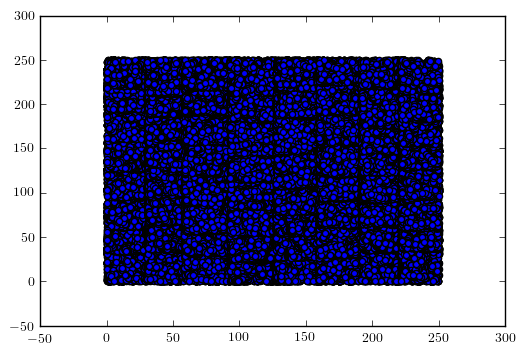

In [82]:
#Check for positions of the subhalos
plt.scatter(Reduced_subs["halo_x"],Reduced_subs["halo_y"])

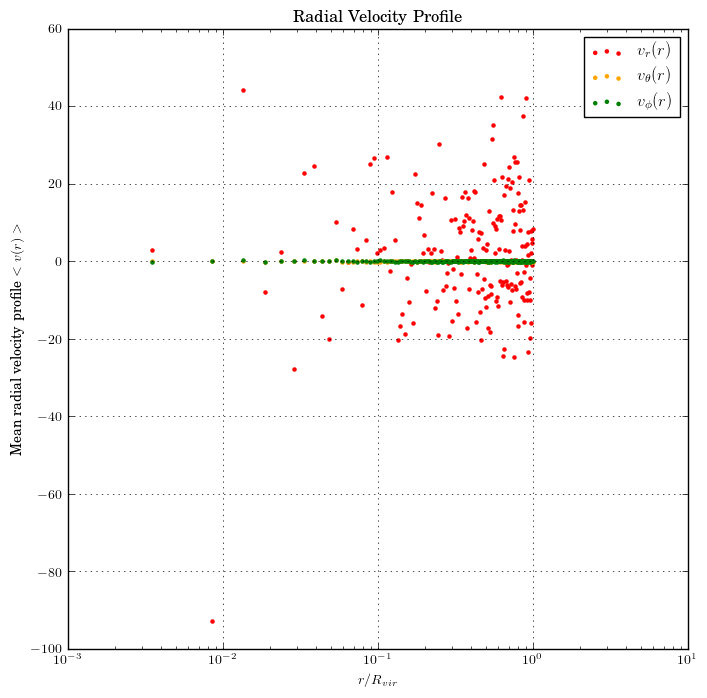

In [107]:
#Another approach, try to compute average velocities in cartesian coordinates and transform into spherical ones afterwards

aver_vx = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_vx'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_vy = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_vy'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_vz = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_vz'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_x'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_y = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_y'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_z = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_z'],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

#Go to Spherical coordinates

aver_vr = (aver_x*aver_vx+aver_y*aver_vy+aver_z*aver_vz)/np.sqrt(aver_x**2+aver_y**2+aver_z**2)

aver_vth= (aver_z*(aver_x*aver_vx+aver_y*aver_vy)-aver_vz*(aver_x**2+aver_y**2))/(aver_x**2+aver_y**2+aver_z**2)/np.sqrt(aver_x**2+aver_y**2)

aver_vph=(aver_vx*aver_y-aver_x*aver_vy)/(aver_x**2+aver_y**2)




#Plot the radial velocity profile

# Create a new figure 
fig = plt.figure(figsize=(8,8), dpi=80)

# Create subplots
plot_profile = fig.add_subplot(111)

# Plot power spectrum
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(1e-304, 10)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'Mean radial velocity profile $<v(r)> $')

plot_profile.scatter(rbins_midpoints, aver_vr, color="red", label=r"$v_r(r)$", marker=".")

plot_profile.scatter(rbins_midpoints, aver_vth, color="orange" ,label=r"$v_{\theta}(r)$", marker=".")

plot_profile.scatter(rbins_midpoints, aver_vph, color="green", label=r"$v_{\phi}(r)$", marker=".")

plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Radial Velocity Profile")
# Save figure using 80 dots per inch
plt.savefig("RadialVelocityProfile.pdf",dpi=80)


6) The anisotropic parameter
=======

In [110]:
#Calculate the correlated streaming part of the component velocities <v_i v_i > in order to calculate 
#sigma_i^2= <v_i v_i> - <v_i>^2
r = np.sqrt(Reduced_subs["halo_x"]**2+Reduced_subs["halo_y"]**2+Reduced_subs["halo_z"]**2)

M = r**4 *(Reduced_subs["halo_x"]**2+Reduced_subs["halo_y"]**2)

N = (Reduced_subs["halo_x"]**2+Reduced_subs["halo_y"]**2)

aver_vx2 = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_vx']**2,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_vy2 = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_vy']**2,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_vz2 = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs['halo_vz']**2,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xOverR2 = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']/r)**2,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_yOverR2 = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_y']/r)**2,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_zOverR2 = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_z']/r)**2,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xyOverR2 = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']*Reduced_subs["halo_y"]/r)**2,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xzOverR2 = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']*Reduced_subs["halo_z"]/r)**2,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_yzOverR2 = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_y']*Reduced_subs["halo_z"]/r)**2,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_x2z2OverM = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']**2 *Reduced_subs["halo_z"]**2/M),
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xyz2OverM = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']*Reduced_subs["halo_y"]*Reduced_subs["halo_z"]**2)/M,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x3zOverM = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']**3 *Reduced_subs["halo_z"]/M),
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xy2zOverM = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']*Reduced_subs["halo_y"]**2 *Reduced_subs["halo_z"]/M),
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_y2z2OverM = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_y']**2 *Reduced_subs["halo_z"]**2)/M,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x2yzOverM = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']**2 *Reduced_subs["halo_y"]*Reduced_subs["halo_z"]/M),
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_y3zOverM = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_y']**3 *Reduced_subs["halo_z"]/M),
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x4OverM = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']**4 )/M,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x2y2OverM = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs['halo_x']**2 *Reduced_subs["halo_y"]**2)/M,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)



aver_y2OverN = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs["halo_y"]**2)/N,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xyOverN = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs["halo_y"]*Reduced_subs["halo_x"])/N,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_x2OverN = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, (Reduced_subs["halo_x"]**2)/N,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)






In [127]:
#Mixed streaming motions


aver_vxvy = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs["halo_vx"]*Reduced_subs["halo_vy"],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_vxvz = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_vx"]*Reduced_subs["halo_vz"],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_vyvz = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_vy"]*Reduced_subs["halo_vz"],
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

In [128]:
#Go to Spherical coordinates
#<v_r v_r>
aver_vr2 = aver_xOverR2*aver_vx2 +aver_yOverR2*aver_vy2+aver_zOverR2*aver_vz2+2*(aver_vxvy*aver_xyOverR2 + aver_vxvz*aver_xzOverR2+aver_vyvz*aver_yzOverR2)
#<v_th v_th>
aver_vth2= aver_vx2*aver_x2z2OverM+2*aver_vxvy*aver_xyz2OverM-2*aver_vxvz*aver_x3zOverM-2*aver_vxvz*aver_xy2zOverM+aver_vy2*aver_y2z2OverM-2*aver_vyvz*aver_x2yzOverM-2*aver_vyvz*aver_y3zOverM+aver_vz2*aver_x4OverM +2*aver_vz2*aver_x2y2OverM+aver_vz2*aver_y4OverM
#<v_ph v_ph>
aver_vph2= aver_vx2*aver_y2OverN - 2* aver_vxvy*aver_xyOverN + aver_vy2*aver_x2OverN



In [142]:
O = np.sqrt(N)*r**3

aver_x2zOverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]**2 *Reduced_subs["halo_z"]/O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xyzOverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]*Reduced_subs["halo_y"]*Reduced_subs["halo_z"]/O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x3OverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]**3 /O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xy2OverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]*Reduced_subs["halo_y"]**2 /O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xz2OverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]*Reduced_subs["halo_z"]**2 /O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_y2zOverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_y"]**2 *Reduced_subs["halo_z"]/O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x2yOverO= radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]**2 *Reduced_subs["halo_y"]/O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_y3OverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_y"]**3 /O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_yz2OverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_y"]*Reduced_subs["halo_z"]**2 /O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x2zOverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]**2 *Reduced_subs["halo_z"]/O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_zOverO = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_z"]/O,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

In [144]:
P = r*N

aver_xyOverP = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]*Reduced_subs["halo_y"]/P,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x2OverP= radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]**2 /P,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_y2OverP = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_y"]**2 /P,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_yzOverP = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs["halo_y"]* Reduced_subs["halo_z"]/P,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xzOverP = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]*Reduced_subs["halo_z"]/P,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


In [146]:
K = r**2 * N**(3/2)

aver_xyzOverK = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos, Reduced_subs["halo_y"]* Reduced_subs["halo_x"]*Reduced_subs["halo_z"]/K,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_x2zOverK = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]**2 *Reduced_subs["halo_z"]/K,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_y2zOverK = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_y"]**2 *Reduced_subs["halo_z"]/K,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_y3OverK = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_y"]**3 /K,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)


aver_x3OverK = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]**3 /K,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)

aver_xy2OverK = radial_profile_3d(Reduced_hosts_pos, Reduced_subs_pos,  Reduced_subs["halo_x"]*Reduced_subs["halo_y"]**2 /K,
                           rbins_normalized = rbins_normalized,
                           normalize_rbins_by = Reduced_hosts['halo_rvir'],
                           period=halocat.Lbox)



In [151]:
#<v_r v_th>
aver_vr_vth = aver_vx2*aver_x2zOverO +2*aver_vxvy * aver_xyzOverO - aver_vxvz* aver_x3OverO - aver_vxvz*aver_xy2OverO + aver_vxvz*aver_xz2OverO + aver_vy2*aver_y2zOverO-aver_vyvz * aver_x2zOverO-aver_vyvz*aver_y3OverO + aver_vyvz*aver_yz2OverO-aver_vz2*aver_x2zOverO-aver_vz2*aver_vy2*aver_zOverO
#<v_r v_ph>
aver_vr_vph = aver_vx2*aver_xyOverP - aver_vxvy*aver_x2OverP + aver_vxvy*aver_y2OverP+aver_vxvz*aver_yzOverP-aver_vy2*aver_xyOverP-aver_vyvz*aver_xzOverP
#<v_th v_ph>
aver_vth_vph = aver_vx2*aver_xyzOverK-aver_vxvy*aver_x2zOverK+aver_vxvy*aver_y2zOverK - aver_vxvz*aver_x2zOverK-aver_vxvz*aver_y3OverK - aver_vy2*aver_xyzOverK + aver_vyvz*aver_x3OverK + aver_vyvz*aver_xy2OverK 

In [129]:
#The Velocity Dispersions are then given by:
sigma_r_2 = aver_vr2 - aver_vr**2

sigma_th_2 = aver_vth2 - aver_vth**2

sigma_ph_2 = aver_vph2 - aver_vr**2



In [130]:
#Define the velocity anisotropy


beta_th = 1-sigma_th_2/sigma_r_2
#Filter unphysical value
beta_th = (beta_th<2)&(beta_th>-2)

beta_ph = 1-sigma_ph_2/sigma_r_2 
beta_ph = (beta_ph<2)&(beta_ph>-2)
#In the Jeans equation we assume spherical symmetry : beta_th=beta_ph


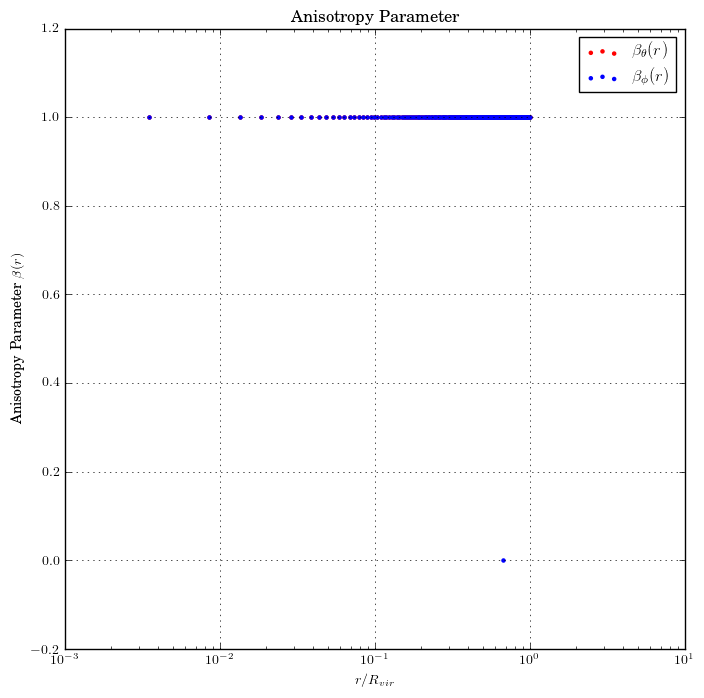

In [131]:
# Create a new figure 
fig = plt.figure(figsize=(8,8), dpi=80)

# Create subplots
plot_profile = fig.add_subplot(111)

# Plot power spectrum
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(1e-304, 10)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'Anisotropy Parameter $\beta (r) $')

plot_profile.scatter(rbins_midpoints,beta_th, color="red", label=r"$\beta_{\theta}(r)$", marker=".")
plot_profile.scatter(rbins_midpoints,beta_ph, color="blue", label=r"$\beta _{\phi}(r)$", marker=".")



plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Anisotropy Parameter")
# Save figure using 80 dots per inch
plt.savefig("AnisotropyParameter.pdf",dpi=80)


C:\Users\ThimoPreis\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


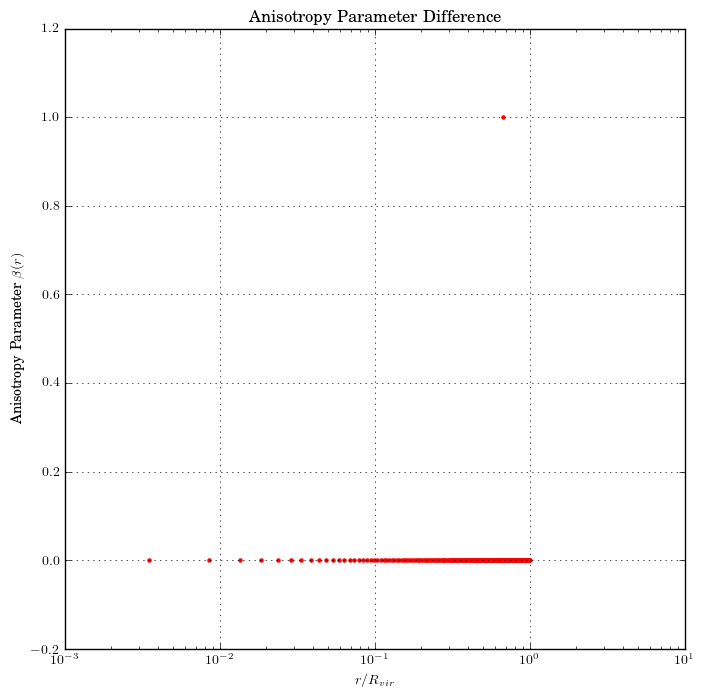

In [132]:
# Create a new figure 
fig = plt.figure(figsize=(8,8), dpi=80)

# Create subplots
plot_profile = fig.add_subplot(111)

# Plot power spectrum
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(1e-304, 10)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'Anisotropy Parameter $\beta (r) $')

plot_profile.scatter(rbins_midpoints,beta_th-beta_ph, color="red", marker=".")

plt.title("Anisotropy Parameter Difference")
# Save figure using 80 dots per inch
plt.savefig("AnisotropyParameterDifference.pdf",dpi=80)

5)Dispersion profiles
==

In [133]:
#Calculate the pairwise radial velocity dispersion between the subhalos and their respective hosts
from halotools.mock_observables import radial_pvd_vs_r

rbins_normalized1 = np.linspace(0.001, 1, 200)
rbins_midpoints = (rbins_normalized[:-1] + rbins_normalized[1:])/2.

sigma_r_12 = radial_pvd_vs_r(sample1=Reduced_hosts_pos,velocities1=Reduced_hosts_vel,
                           rbins_normalized  = rbins_normalized1,
                           normalize_rbins_by  = Reduced_hosts['halo_rvir'],
                           sample2=Reduced_subs_pos,velocities2=Reduced_subs_vel,
                           period=halocat.Lbox)

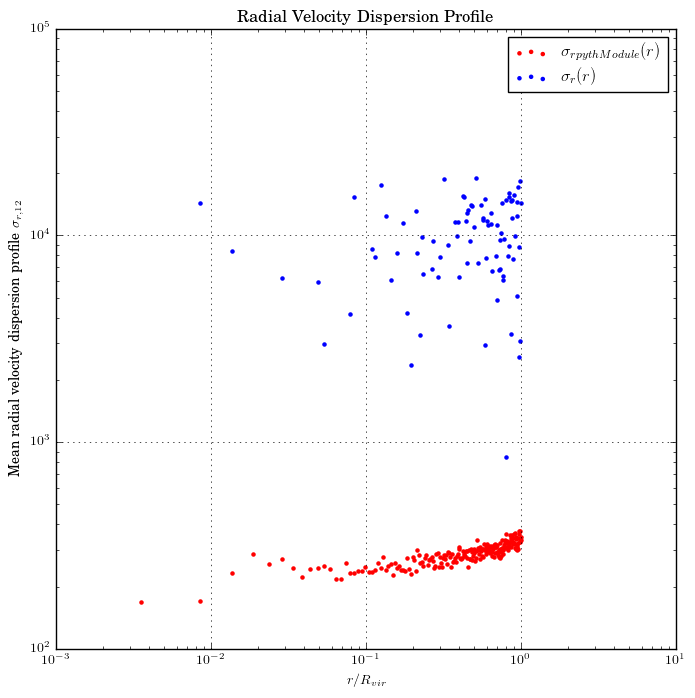

In [134]:


#Plot the radial velocity profile

# Create a new figure 
fig = plt.figure(figsize=(8,8), dpi=80)

# Create subplots
plot_profile = fig.add_subplot(111)

# Plot power spectrum
plot_profile.set_xscale('log')
plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(1e-304, 10)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'Mean radial velocity dispersion profile $\sigma_{r,12} $')

plot_profile.scatter(rbins_midpoints, sigma_r_12, color="red", label=r"$\sigma_r_{pythModule}(r)$", marker=".")
plot_profile.scatter(rbins_midpoints, np.sqrt(sigma_r_2), color="blue", label=r"$\sigma_r(r)$", marker=".")


plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Radial Velocity Dispersion Profile")
# Save figure using 80 dots per inch
plt.savefig("RadialVelocityDispersionProfile.pdf",dpi=80)

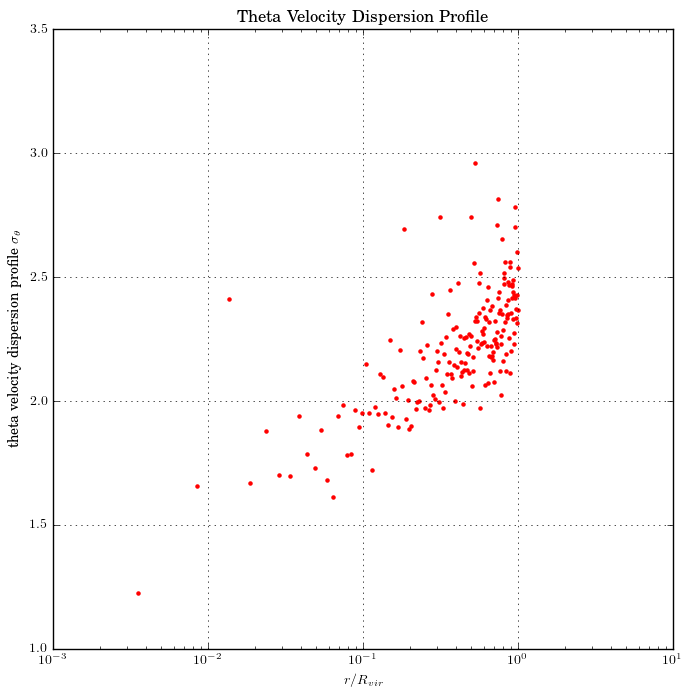

In [138]:


#Plot the theta velocity profile

# Create a new figure 
fig = plt.figure(figsize=(8,8), dpi=80)

# Create subplots
plot_profile = fig.add_subplot(111)

# Plot power spectrum
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(1e-304, 10)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'theta velocity dispersion profile $\sigma_{\theta} $')

plot_profile.scatter(rbins_midpoints, np.sqrt(sigma_th_2), color="red", marker=".")


plt.title("Theta Velocity Dispersion Profile")
# Save figure using 80 dots per inch
plt.savefig("ThetaVelocityDispersionProfile.pdf",dpi=80)

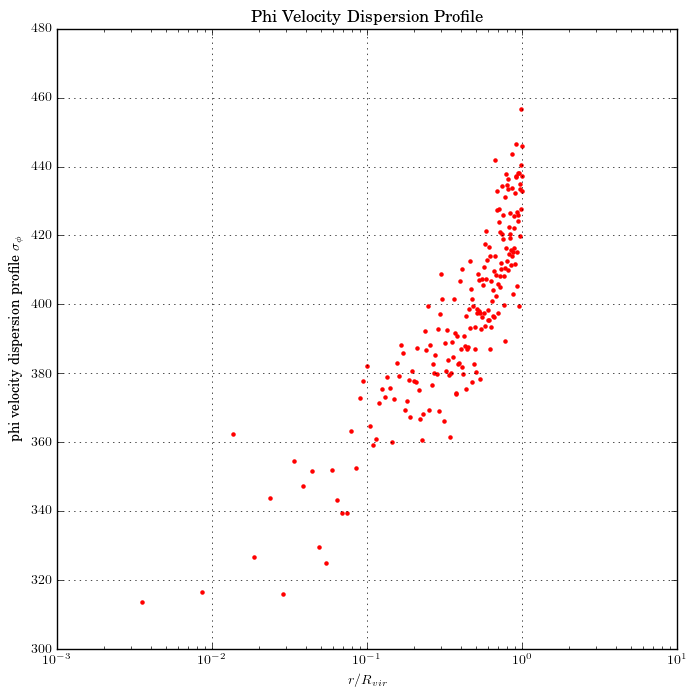

In [154]:

#Plot the phi velocity profile

# Create a new figure 
fig = plt.figure(figsize=(8,8), dpi=80)

# Create subplots
plot_profile = fig.add_subplot(111)

# Plot power spectrum
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(1e-304, 10)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'phi velocity dispersion profile $\sigma_{\phi} $')


plot_profile.scatter(rbins_midpoints, np.sqrt(sigma_ph_2), color="red",label=r"$v_{\phi}$", marker=".")


plt.title("Phi Velocity Dispersion Profile")
# Save figure using 80 dots per inch
plt.savefig("PhiVelocityDispersionProfile.pdf",dpi=80)

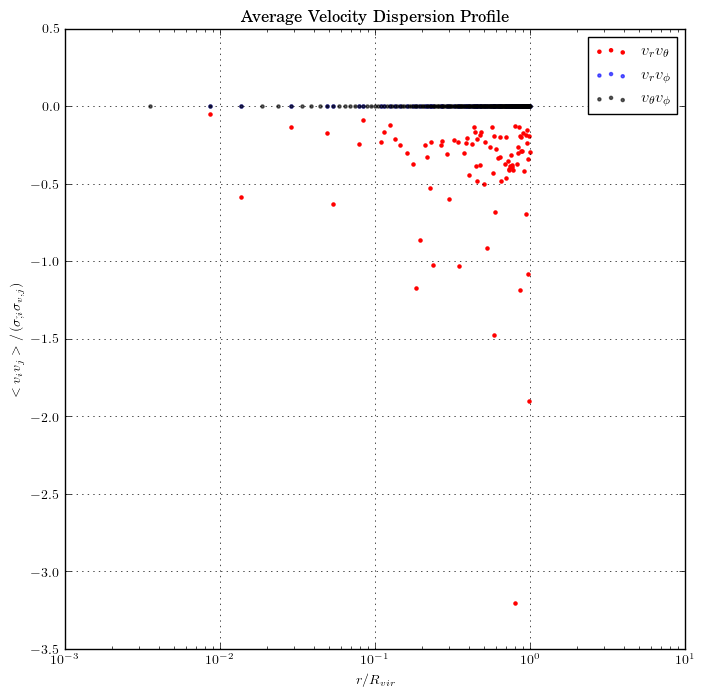

In [157]:

#Plot the average velocity profiles

# Create a new figure 
fig = plt.figure(figsize=(8,8), dpi=80)

# Create subplots
plot_profile = fig.add_subplot(111)

# Plot power spectrum
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(1e-304, 10)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'$<v_i v_j>/\left(\sigma_{\v,i} \sigma_{v,j}\right) $')

plot_profile.scatter(rbins_midpoints, aver_vr_vth/np.sqrt(sigma_r_2)/np.sqrt(sigma_th_2), color="red",label=r"$v_r v_{\theta}$", marker=".")
plot_profile.scatter(rbins_midpoints, aver_vr_vph/np.sqrt(sigma_r_2)/np.sqrt(sigma_ph_2), color="blue",label=r"$v_r v_{\phi}$", marker=".",alpha=0.6)
plot_profile.scatter(rbins_midpoints, aver_vth_vph/np.sqrt(sigma_th_2)/np.sqrt(sigma_ph_2), color="black",label=r"$v_{\theta} v_{\phi}$", marker=".",alpha=0.6)


plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Average Velocity Dispersion Profile")
# Save figure using 80 dots per inch
plt.savefig("AverageVelocityDispersionProfiles.pdf",dpi=80)